# GX 6004.001: Introduction to Deep Learning (Session 11)

## Overview

Because of their remarkable success in digital image processing, among other areas of data science, the origin of neural networks, the precusor to deep learning, is claimed by many disciplines and by many people.
* The "electronic brain" and the neuroscience of the 1950's.
* Computer science: Character recongition and the U.S. Postal Service. 
* Economics and finance: Let's make a million dollars!

Like many approaches in data science, the technique has waxed and waned through the ages, seemingly rediscovered each time.

Let's not focus on the past (despite my personal interest on the origin of algorithms).  Let's focus on the present.  Fortunately, we've already seen a simple example of a neural network: the logit classifier.
* The logit classifier is a simple neural network: feed-forward MLP with one hidden layer.
* A neural network builds on this simple concept by introducing many "logits" and tying them together with weights.
* We estimated the $\beta$'s of the logits via maximum likelihood.
* We tie them with weights that we also esimate via maximum likelihood.

## An Electronic Brain: Mimic Mammalian Neuron

Populating the interactive namespace from numpy and matplotlib


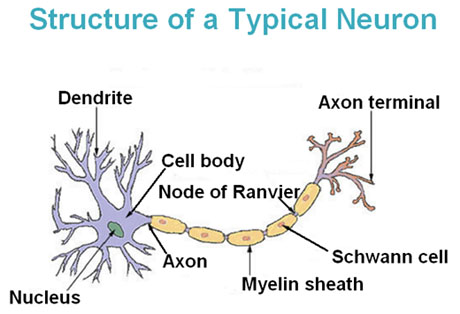

In [1]:
%pylab inline
from PIL import Image
import urllib.request as url
import io

fd = url.urlopen("https://upload.wikimedia.org/wikipedia/commons/b/bd/Neuron.jpg")
image_file = io.BytesIO(fd.read())
Image.open(image_file)

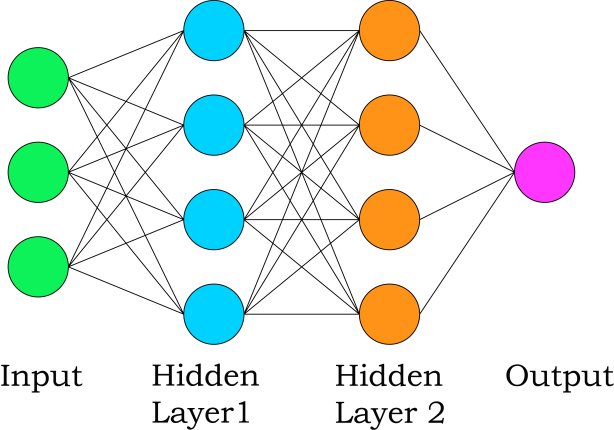

In [2]:
fd = url.urlopen("https://en.mlab.ai/sites/default/files/inline-images/neural1_1.jpg")
image_file = io.BytesIO(fd.read())
Image.open(image_file)

### Computer science 
* Character recongition, the U.S. Postal Service, and Yann LeCun's famous MNIST data. 
* A Cambrian-like explosion since 2008.

### Economics and finance 
* See, among others, papers by Ron Gallant (UNC Chapel Hill), George Tauchen (Duke), and Hal White (UCSD). 
* Seemingly died out, despite tremendous increase in ease of use. 
* We will explore a possible explanation.

### Other disciplines?
* Unclear.
* Success is reliant on stability of correlation patterns through space and over time.
* 'I will look the same tomorrow in Midtown Manhattan.'

In [3]:
# Load the libraries.

%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt  
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
import pymc3 as pm
import theano
from mpl_toolkits.mplot3d import Axes3D
import fix_yahoo_finance as yf
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.datasets import mnist

Using TensorFlow backend.


### A Motivating Example: A Logic Gate

In [4]:
np.random.seed(1907)
f1 = np.random.randint(0, 2, 10000)
f2 = np.random.randint(0, 2, 10000)
label = np.logical_xor(f1, f2) * 1
data = pd.DataFrame({'label':label, 'f1':f1, 'f2':f2})
data.head(10)

,f1,f2,label
0,1,1,0
1,1,0,1
2,1,1,0
3,0,0,0
4,1,1,0
5,1,0,1
6,1,1,0
7,0,0,0
8,0,0,0
9,1,0,1


In [5]:
datatrain, datatest = train_test_split(data, test_size = 0.2, random_state = 6281993)

In [6]:
mod = smf.ols(formula='label ~ f1 + f2', data = datatrain).fit()
print(mod.summary())
datatest['lm_hat'] = mod.predict(exog = datatest)

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8976
Date:                Wed, 21 Nov 2018   Prob (F-statistic):              0.408
Time:                        18:08:16   Log-Likelihood:                -7256.5
No. Observations:               10000   AIC:                         1.452e+04
Df Residuals:                    9997   BIC:                         1.454e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5067      0.009     58.246      0.0

In [7]:
print(datatest['label'].describe())
print("")
print(datatest['lm_hat'].describe())

count    2000.000000
mean        0.499500
std         0.500125
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

count    2000.000000
mean        0.505246
std         0.006665
min         0.495912
25%         0.503682
50%         0.506746
75%         0.514516
max         0.514516
Name: lm_hat, dtype: float64


In [8]:
print((1 - 0.5)**2)
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['lm_hat']))

0.25
The MSE is 0.250044


In [9]:
mod = smf.logit(formula='label ~ f1 + f2', data = datatrain).fit()
print(mod.summary())
datatest['logit_hat'] = mod.predict(exog = datatest)

Optimization terminated successfully.
         Current function value: 0.692937
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7997
Method:                           MLE   Df Model:                            2
Date:                Wed, 21 Nov 2018   Pseudo R-squ.:               0.0001723
Time:                        18:08:16   Log-Likelihood:                -5543.5
converged:                       True   LL-Null:                       -5544.4
                                        LLR p-value:                    0.3846
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0337      0.039      0.866      0.386      -0.043       0.110
f1            -0.0500      0.

In [10]:
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['logit_hat']))

The MSE is 0.250073


In [11]:
print(datatest.head(20))

      f1  f2  label    lm_hat  logit_hat
2803   0   1      1  0.514516   0.517343
5397   0   1      1  0.514516   0.517343
1739   1   1      0  0.503682   0.504839
5103   0   1      1  0.514516   0.517343
3750   0   0      0  0.506746   0.508434
1654   1   0      1  0.495912   0.495924
3057   1   0      1  0.495912   0.495924
8124   0   0      0  0.506746   0.508434
6477   0   0      0  0.506746   0.508434
6597   1   0      1  0.495912   0.495924
8399   1   0      1  0.495912   0.495924
494    1   1      0  0.503682   0.504839
4775   1   0      1  0.495912   0.495924
3787   0   0      0  0.506746   0.508434
7204   0   0      0  0.506746   0.508434
1951   0   1      1  0.514516   0.517343
2198   1   0      1  0.495912   0.495924
4699   0   0      0  0.506746   0.508434
2602   0   1      1  0.514516   0.517343
6044   1   0      1  0.495912   0.495924


In [12]:
X_train = datatrain[['f1', 'f2']].values
y_train = datatrain['label'].values
X_test = datatest[['f1', 'f2']].values
y_test = datatest['label'].values
dim = X_train.shape[1]

#### Notes
* Start with five perceptrons and evaluate the performance using the MSE metric.
* Increase number of perceptrons.
* Increase number of hidden layers.
* Keras makes fitting MLPs **incredibly** easy.
* What's 'relu'?  It is the rectified linear activation unit.  Piecewise linear representation of the logit.

In [13]:
np.random.seed(1066)
model = Sequential()
model.add(Dense(5, activation='relu', input_dim=dim))
#model.add(Dense(25, activation='relu', input_dim=dim))
#model.add(Dense(25, activation='relu', input_dim=dim))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
datatest['dl_hat'] = model.predict(X_test)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
0s - loss: 0.6461 - acc: 0.7409 - val_loss: 0.6420 - val_acc: 0.7495
Epoch 2/10
0s - loss: 0.6353 - acc: 0.7525 - val_loss: 0.6310 - val_acc: 0.7495
Epoch 3/10
0s - loss: 0.6237 - acc: 0.7525 - val_loss: 0.6190 - val_acc: 0.7495
Epoch 4/10
0s - loss: 0.6112 - acc: 0.8900 - val_loss: 0.6060 - val_acc: 1.0000
Epoch 5/10
0s - loss: 0.5975 - acc: 1.0000 - val_loss: 0.5918 - val_acc: 1.0000
Epoch 6/10
0s - loss: 0.5828 - acc: 1.0000 - val_loss: 0.5767 - val_acc: 1.0000
Epoch 7/10
0s - loss: 0.5672 - acc: 1.0000 - val_loss: 0.5609 - val_acc: 1.0000
Epoch 8/10
0s - loss: 0.5508 - acc: 1.0000 - val_loss: 0.5442 - val_acc: 1.0000
Epoch 9/10
0s - loss: 0.5339 - acc: 1.0000 - val_loss: 0.5271 - val_acc: 1.0000
Epoch 10/10
0s - loss: 0.5165 - acc: 1.0000 - val_loss: 0.5099 - val_acc: 1.0000


In [14]:
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['dl_hat']))

The MSE is 0.162931


In [15]:
print(datatest.head(20))

      f1  f2  label    lm_hat  logit_hat    dl_hat
2803   0   1      1  0.514516   0.517343  0.762013
5397   0   1      1  0.514516   0.517343  0.762013
1739   1   1      0  0.503682   0.504839  0.433112
5103   0   1      1  0.514516   0.517343  0.762013
3750   0   0      0  0.506746   0.508434  0.432586
1654   1   0      1  0.495912   0.495924  0.529439
3057   1   0      1  0.495912   0.495924  0.529439
8124   0   0      0  0.506746   0.508434  0.432586
6477   0   0      0  0.506746   0.508434  0.432586
6597   1   0      1  0.495912   0.495924  0.529439
8399   1   0      1  0.495912   0.495924  0.529439
494    1   1      0  0.503682   0.504839  0.433112
4775   1   0      1  0.495912   0.495924  0.529439
3787   0   0      0  0.506746   0.508434  0.432586
7204   0   0      0  0.506746   0.508434  0.432586
1951   0   1      1  0.514516   0.517343  0.762013
2198   1   0      1  0.495912   0.495924  0.529439
4699   0   0      0  0.506746   0.508434  0.432586
2602   0   1      1  0.514516  

## Example 1: The Multilayered Perceptron

#### Notes
* The multilayered perceptron (MLP) has been around for decades.
* Consider the simplest perceptron: the logit.
* Technically, feed-forward one-layered perceptron using the logitistic action function.
* Connect large number of logits using weights whose optimal values are computed as a more extensive optimization problem.
* If we created multiple layers of such "linked logits" we obtain the multilayered perceptron (MLP).
* Import the LeCun et al. MNIST dataset of handwritten characters.
* Remember we can turn images into data in an Excel spreadsheet.

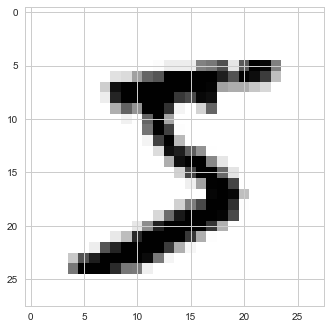

Training label(s): [5]


In [16]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

num_digits = 1
for i in range(num_digits):
    plt.subplot(1, num_digits, i+1)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray_r'))
#    plt.axis('off')
plt.show()
print('Training label(s): %s' % (y_train[0:num_digits],))

### These are grey scale images that can be converted to dataframes
* Consider the idea of placing small squares on these images.  Call them **'pixels'**.  
* Or call them a column in an Excel spreadsheet.  **It is the same thing.**
* The darker the pixel, the larger the value in the Excel cell.  
* In a spreadsheet, the first column would be the number 5.  
* Given these data are 25 X 25 pixels of grey scale: there are $25^2 + 1$ columns.

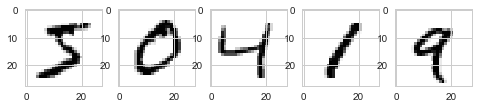

Training labels: [5 0 4 1 9]


In [17]:
num_digits = 5
for i in range(num_digits):
    plt.subplot(1, num_digits, i+1)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray_r'))
#    plt.axis('off')
plt.show()
print('Training labels: %s' % (y_train[0:num_digits],))

In [18]:
# Preprocess the NMIST data, which are stored as 28 X 28 pixels of grayscale between 1 and 255.

num_pixels = X_train.shape[1] * X_train.shape[2]
X_train_pp = (X_train.reshape(X_train.shape[0], num_pixels).astype('float32')) / 255
X_test_pp = (X_test.reshape(X_test.shape[0], num_pixels).astype('float32')) / 255

In [19]:
# Quickly ensure everything has been normalized.

#print(X_train_pp.mean(axis = 0))
#print('')
#print(X_train_pp[1])
print(y_train[0])
print(X_train_pp[0])

5
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          

In [20]:
# Keras needs the labels as categorical matrics.

y_train_pp = np_utils.to_categorical(y_train)
y_test_pp = np_utils.to_categorical(y_test)
num_classes = y_test_pp.shape[1]

In [21]:
# Define a simple MLP with three hidden layers of 150, 300, and 150 neurons, respectively.
# First line of code: set a seed for replication.
# Second: Define the model to be sequential using Keras.
# Next three lines: 
    # Define the MLP, where number units sets the number of neurons
    # input_dim is the dimension of the data flowing in and passing through the layers.  It remains fixed.
    # activation is the sigmoidal shape of a neuron, here using the rectified linear unit or 'relu'
# Final line: 
    # We map into the number of classes we have for the digits with the softmax activation, which just chooses
    # the most probable.

np.random.seed(1066)
model = Sequential()
model.add(Dense(units=150, input_dim=num_pixels, activation='relu'))
model.add(Dense(units=300, input_dim=num_pixels, activation='relu'))
model.add(Dense(units=150, input_dim=num_pixels, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

# Compile, fit, and generate scores and predicted probabilities.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pp, y_train_pp, validation_data=(X_test_pp, y_test_pp), epochs=10, batch_size=200, verbose=2)
scores = model.evaluate(X_test_pp, y_test_pp, verbose=0)
prob = model.predict(X_test_pp)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
5s - loss: 0.3267 - acc: 0.9073 - val_loss: 0.1534 - val_acc: 0.9552
Epoch 2/10
5s - loss: 0.1134 - acc: 0.9655 - val_loss: 0.1200 - val_acc: 0.9632
Epoch 3/10
3s - loss: 0.0782 - acc: 0.9762 - val_loss: 0.0961 - val_acc: 0.9723
Epoch 4/10
4s - loss: 0.0587 - acc: 0.9816 - val_loss: 0.0869 - val_acc: 0.9722
Epoch 5/10
5s - loss: 0.0444 - acc: 0.9860 - val_loss: 0.0818 - val_acc: 0.9747
Epoch 6/10
4s - loss: 0.0363 - acc: 0.9882 - val_loss: 0.0772 - val_acc: 0.9755
Epoch 7/10
4s - loss: 0.0289 - acc: 0.9907 - val_loss: 0.0786 - val_acc: 0.9774
Epoch 8/10
4s - loss: 0.0247 - acc: 0.9918 - val_loss: 0.0758 - val_acc: 0.9786
Epoch 9/10
4s - loss: 0.0173 - acc: 0.9945 - val_loss: 0.0847 - val_acc: 0.9779
Epoch 10/10
3s - loss: 0.0179 - acc: 0.9937 - val_loss: 0.0810 - val_acc: 0.9773


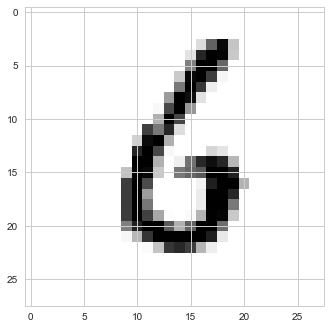

Classified as a 6 with probability 0.999790


In [22]:
# Examine the performance of the 50th image in the test set.

img = 50
plt.imshow(X_test[img], cmap=plt.get_cmap('gray_r'))
#plt.axis('off')
plt.show()
print('Classified as a %d with probability %f' % (prob[img].argmax(), max(prob[img])))

In [23]:
# Standard measures of performance.
# First the accuracy rate on the test or validation set.

from sklearn.metrics import accuracy_score
print('Accuracy Rate: %f' % accuracy_score(y_test, prob.argmax(axis = 1)))

Accuracy Rate: 0.977300


In [24]:
# Next the confusion matrix, which shows correct and incorrect classification on the test set.

from sklearn.metrics import confusion_matrix
print('Confusion matrix:\n%s' % confusion_matrix(y_test, prob.argmax(axis = 1)))

Confusion matrix:
[[ 970    0    1    1    0    1    2    1    2    2]
 [   0 1123    4    1    0    1    1    0    5    0]
 [   2    0 1017    2    1    0    0    7    2    1]
 [   0    0    7  989    0    4    0    3    2    5]
 [   2    1    3    0  965    0    2    2    0    7]
 [   2    0    0   16    1  865    3    0    2    3]
 [   9    2    3    1    3    2  933    0    5    0]
 [   3    2   17    6    1    0    0  995    1    3]
 [   3    0    2    7    3    5    0    3  948    3]
 [   2    4    0    8    8    4    0    9    6  968]]


In [25]:
# Next a classification report.

from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_test, prob.argmax(axis = 1)))

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       980
          1       0.99      0.99      0.99      1135
          2       0.96      0.99      0.98      1032
          3       0.96      0.98      0.97      1010
          4       0.98      0.98      0.98       982
          5       0.98      0.97      0.98       892
          6       0.99      0.97      0.98       958
          7       0.98      0.97      0.97      1028
          8       0.97      0.97      0.97       974
          9       0.98      0.96      0.97      1009

avg / total       0.98      0.98      0.98     10000



In [26]:
# Finally, identify cases that failed.

(y_test - prob.argmax(axis = 1) > 0).nonzero()

(array([ 151,  247,  340,  445,  448,  495,  551,  582,  674,  684,  839,
         877,  882,  965, 1003, 1014, 1178, 1226, 1247, 1319, 1326, 1425,
        1444, 1530, 1553, 1554, 1569, 1670, 1709, 1754, 1800, 1901, 1941,
        1952, 2016, 2035, 2098, 2118, 2135, 2189, 2291, 2293, 2298, 2325,
        2387, 2395, 2582, 2597, 2607, 2648, 2654, 2720, 2810, 2915, 2921,
        2927, 2939, 3005, 3060, 3117, 3173, 3289, 3422, 3503, 3520, 3549,
        3558, 3559, 3567, 3604, 3629, 3662, 3749, 3751, 3767, 3780, 3808,
        3838, 3853, 3869, 4078, 4163, 4207, 4224, 4294, 4360, 4425, 4433,
        4443, 4487, 4497, 4534, 4536, 4540, 4761, 4807, 4814, 4823, 4861,
        4890, 4956, 4966, 5654, 5676, 5734, 5757, 5887, 5937, 5982, 6042,
        6071, 6166, 6560, 6571, 6576, 6625, 6632, 6755, 6847, 7107, 7800,
        7821, 8311, 8316, 8453, 8519, 9009, 9015, 9019, 9024, 9280, 9422,
        9427, 9482, 9530, 9587, 9642, 9679, 9692, 9740, 9745, 9755, 9768,
        9770, 9792, 9808, 9888]),)

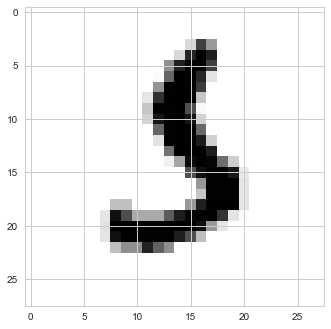

Classified as a 3 with probability 0.998797


In [27]:
img = 340
plt.imshow(X_test[img], cmap=plt.get_cmap('gray_r'))
#plt.axis('off')
plt.show()
print('Classified as a %d with probability %f' % (prob[img].argmax(), max(prob[img])))

#### Lab: Add an additional hidden layer with 300 neurons using the 'relu' activation.  How does your accuracy change?

## Example 2: Convolutional Neural Networks (CNN)

* Expensive computational improvement that you will want to run in a clustered computing environment (unless you have laundry to do).

In [28]:
# Load the libraries.

from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [29]:
# Preprocess the NMIST data, but maintain datastructure for CNN.

X_train_pp = (X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')) / 255
X_test_pp = (X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')) / 255

In [30]:
# Format of basic CNN.
# The first hidden layer is a convolutional layer called a Convolution2D. 
# The layer has 32 feature maps, each of which are 5 X 5, and a rectifier activation function. 
# This is the input layer, expecting images with the structure of [pixels] X [width] X [height].
# A pooling layer is then defined to take the maximum called "MaxPooling2D". 
# The next layer is a regularization using dropout called "Dropout" which eliminates 25% of neurons per layer.
# Next is a layer that converts the 2D matrix data to a vector using "Flatten" 
    # which allows the output to be processed by standard fully connected layers.
# The final connection layer contains 128 neurons and rectifier activation function.
# Everything is finally reduced using perceptron layer.  

np.random.seed(1066)
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile, fit, and generate scores and predicted probabilities.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pp, y_train_pp, validation_data=(X_test_pp, y_test_pp), epochs=5, batch_size=200, verbose=2)
scores = model.evaluate(X_test_pp, y_test_pp, verbose=0)
prob = model.predict(X_test_pp)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
185s - loss: 0.2498 - acc: 0.9289 - val_loss: 0.0811 - val_acc: 0.9748
Epoch 2/5
246s - loss: 0.0746 - acc: 0.9776 - val_loss: 0.0523 - val_acc: 0.9844
Epoch 3/5
228s - loss: 0.0552 - acc: 0.9833 - val_loss: 0.0528 - val_acc: 0.9824
Epoch 4/5
189s - loss: 0.0433 - acc: 0.9869 - val_loss: 0.0358 - val_acc: 0.9897
Epoch 5/5
185s - loss: 0.0357 - acc: 0.9890 - val_loss: 0.0341 - val_acc: 0.9891


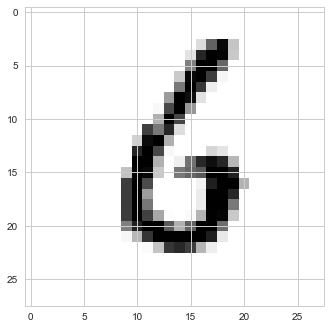

Classified as a 6 with probability 0.999982


In [31]:
# Examine the performance of the 50th image in the test set.

img = 50
plt.imshow(X_test[img], cmap=plt.get_cmap('gray_r'))
#plt.axis('off')
plt.show()
print('Classified as a %d with probability %f' % (prob[img].argmax(), max(prob[img])))

In [32]:
# Substantial, if very costly, improvement.
# Getting these to scale is both an engineering challenge and achievement.
# But when you're dealing with a billion or so pieces of mail, a 100 bp increase in accuracy is a lot of mail.

print('Accuracy Rate: %f' % accuracy_score(y_test, prob.argmax(axis = 1)))
print('')
print('Confusion matrix:\n%s' % confusion_matrix(y_test, prob.argmax(axis = 1)))
print('')
print('Classification Report:')
print(classification_report(y_test, prob.argmax(axis = 1)))
print('')
(y_test - prob.argmax(axis = 1) > 0).nonzero()

Accuracy Rate: 0.989100

Confusion matrix:
[[ 971    1    2    0    0    0    4    1    1    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   1    2 1023    1    0    0    0    5    0    0]
 [   0    0    0 1005    0    2    0    0    3    0]
 [   0    0    1    0  978    0    1    0    1    1]
 [   2    0    0    3    0  885    2    0    0    0]
 [   3    3    0    0    1    1  950    0    0    0]
 [   0    2    7    3    0    0    0 1015    1    0]
 [   4    0    2    2    1    3    2    4  953    3]
 [   0    3    0    0   10    8    1    8    3  976]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       980
          1       0.99      1.00      1.00      1135
          2       0.99      0.99      0.99      1032
          3       0.99      1.00      0.99      1010
          4       0.99      1.00      0.99       982
          5       0.98      0.99      0.99       892
          6       0.99      0.

(array([ 247,  340,  359,  445,  582,  659,  684,  813,  844,  882, 1014,
        1039, 1181, 1202, 1226, 1232, 1247, 1260, 1319, 1326, 1393, 1414,
        1530, 1554, 1686, 1709, 1878, 1901, 2035, 2098, 2118, 2129, 2135,
        2387, 2414, 2654, 2720, 2896, 2939, 3023, 3030, 3060, 3503, 3520,
        3558, 3559, 3751, 3869, 3985, 4075, 4224, 4238, 4248, 4425, 4497,
        4500, 4671, 4731, 4761, 4807, 4823, 4956, 4966, 6091, 6112, 6157,
        6172, 6560, 6571, 6576, 6625, 8408, 9009, 9015, 9019, 9587, 9638,
        9642, 9692, 9770]),)

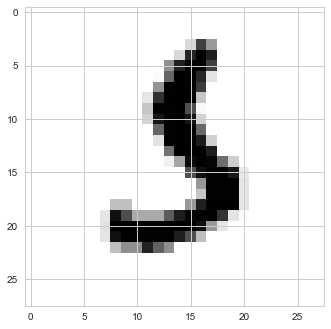

Classified as a 3 with probability 0.673465


In [33]:
img = 340
plt.imshow(X_test[img], cmap=plt.get_cmap('gray_r'))
#plt.axis('off')
plt.show()
print('Classified as a %d with probability %f' % (prob[img].argmax(), max(prob[img])))

# An Application: Return to the Capital Asset Pricing Model (CAPM)
* Early and simple workhorse model in empirical finance

* Let $r_i$ denote the rate of return to asset $i$, $r_f$ denote the known rate of return on a risk-free asset (for example, short-term US government debt), and $r_m$ denote the rate of return to a portfolio (or a market) that includes $i$.  

* The following equation can be derived:

$E(r_i)-r_f = \alpha + \beta \cdot (E(r_m)-r_f)$

* Here, $E(\cdot)$ denotes an expected value (because this is a forward-looking prediction).  In CAPM, $\beta$ captures the sensitivity of an asset’s returns to the returns to a portfolio or to the market on which an asset trades.  In other words, it non-diversifiable risk.  In addition, $\alpha$ measures an asset $i$’s excess (or abnormal) returns.

* Phrases you may have heard: 

    1. The stock's beta is high
    2. The hedge fund is chasing alpha

* Formally, we can express our conjecture as a joint hypothesis:

$H_0: \alpha = 0,\text{ } \beta=1$

$H_1: \text{ not }H_0$

In [34]:
import pandas as pd
import pandas_datareader.data as web
import fix_yahoo_finance
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import patsy
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
import warnings
warnings.simplefilter('ignore')

In [35]:
# Grab 10 years of Apple and NASDAQ data.  
# Note that the old Yahoo Finance API was deprecated.  (Thanks, Verizon!  That Marissa pay-out was steep.)
# Ran Aroussi has developed a fix that saves accessibility to Yahoo Finance. Thanks, Ran! Great stuff. 

start, end = "2006-01-01", "2016-12-31"
aapl_all = web.get_data_yahoo("aapl", start=start, end=end)
nasdaq_all = web.get_data_yahoo("^ixic", start=start, end=end)
aapl = aapl_all['Adj Close']
nasdaq = nasdaq_all['Adj Close']

[*********************100%***********************]  1 of 1 downloaded

### Plot Your Data

Text(0.5,1,'10 Years of AAPL ($/Share)')

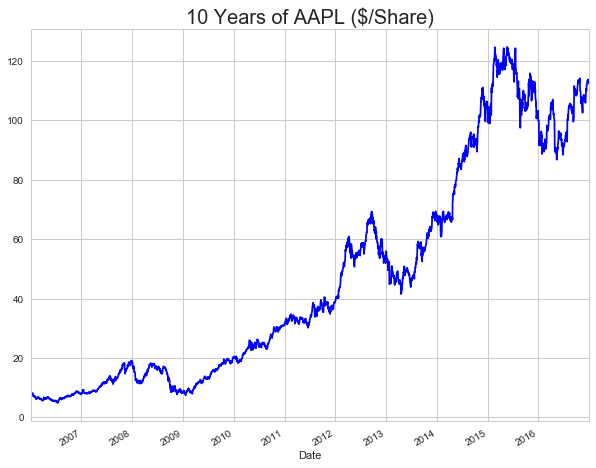

In [36]:
plt.figure(figsize = (10, 8))
aapl.plot(color='blue')
plt.title('10 Years of AAPL ($/Share)', fontsize=20)

Text(0.5,1,'10 Years of NASDAQ Index')

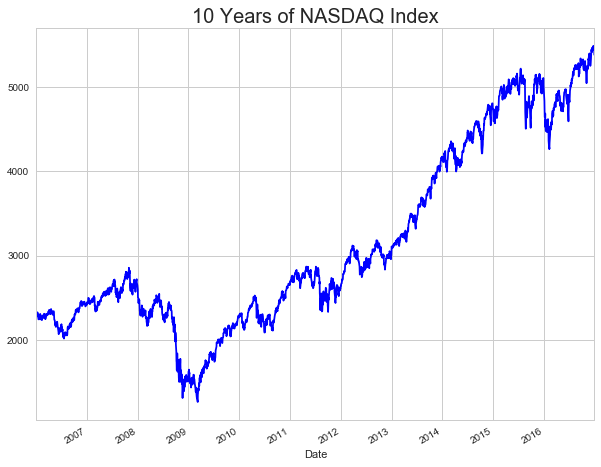

In [37]:
plt.figure(figsize = (10, 8))
nasdaq.plot(color='blue')
plt.title('10 Years of NASDAQ Index', fontsize=20)

In [38]:
# Calculate daily returns.

aapl_returns = np.log(aapl / aapl.shift(1))
nasdaq_returns = np.log(nasdaq / nasdaq.shift(1))
aapl_returns = aapl_returns.dropna()
nasdaq_returns = nasdaq_returns.dropna()

(0, 50)

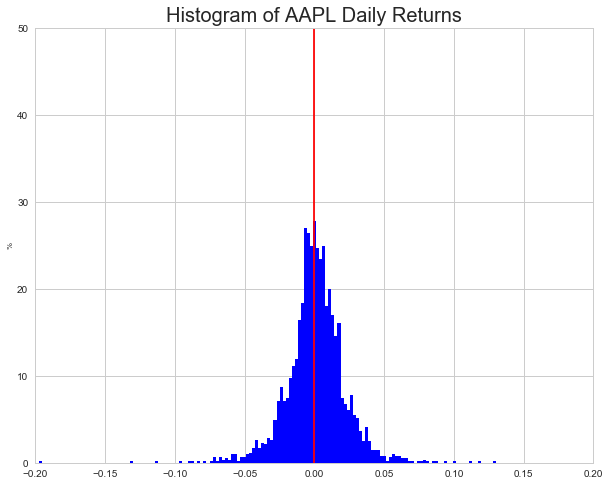

In [39]:
plt.figure(figsize=(10, 8))
plt.hist(aapl_returns, bins=150, normed=True, color='blue')
plt.title('Histogram of AAPL Daily Returns', fontsize=20)
plt.ylabel('%', fontsize=8)
plt.axvline(0, color='red')
plt.xlim(-0.2, 0.2)
plt.ylim(0, 50)

(0, 50)

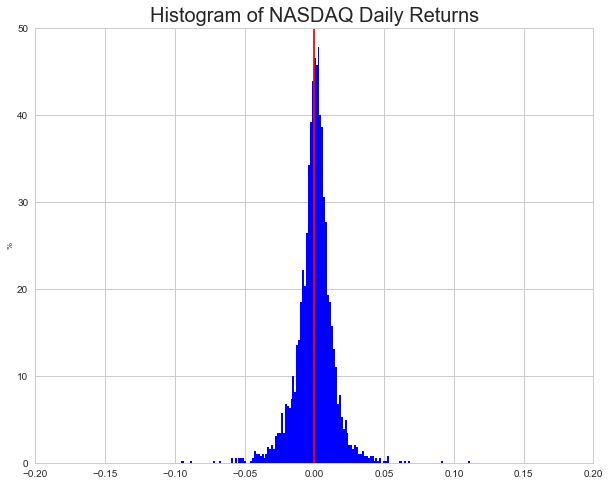

In [40]:
plt.figure(figsize=(10, 8))
plt.hist(nasdaq_returns, bins=150, normed=True, color='blue')
plt.title('Histogram of NASDAQ Daily Returns', fontsize=20)
plt.ylabel('%', fontsize=8)
plt.axvline(0, color='red')
plt.xlim(-0.2, 0.2)
plt.ylim(0, 50)

In [41]:
aapl_returns = pd.DataFrame(aapl_returns)
nasdaq_returns = pd.DataFrame(nasdaq_returns)

In [42]:
print(aapl_returns.describe())
print("")
print(nasdaq_returns.describe())

         Adj Close
count  2768.000000
mean      0.000995
std       0.021157
min      -0.197470
25%      -0.009041
50%       0.000922
75%       0.011983
max       0.130195

         Adj Close
count  2768.000000
mean      0.000316
std       0.013625
min      -0.095877
25%      -0.005389
50%       0.000925
75%       0.006788
max       0.111594


(-0.2, 0.2)

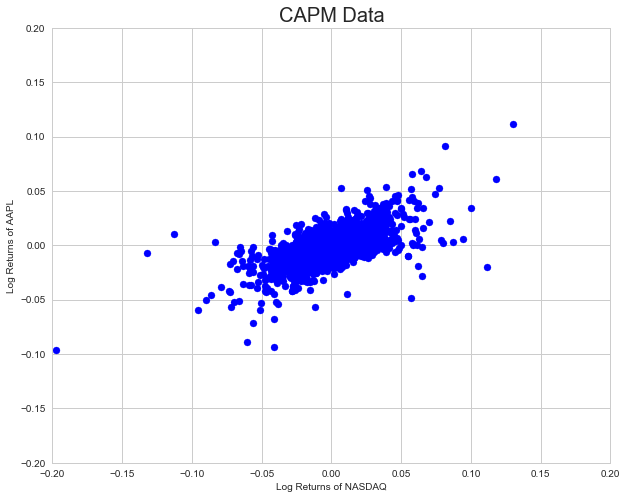

In [43]:
plt.figure(figsize = (10, 8))
plt.scatter(aapl_returns, nasdaq_returns, color='blue')
plt.title('CAPM Data', fontsize = 20)
plt.xlabel('Log Returns of NASDAQ', fontsize = 10)
plt.ylabel('Log Returns of AAPL', fontsize = 10)
plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])

### Frequentist approach 
* Use regression to conduct Neyman-Pearson hypothesis testing.
* Easy to do and covered in earlier lectures.

### Let's do two different things
* Bayesian approach to inference (for fun).
* Predicting returns using deep learning.

## Bayesian CAPM

In [44]:
# This is the syntax for PyMC3, 
# the Python library that allows one to do canned Bayesian estimation.
# See https://pymc-devs.github.io/pymc3/getting_started/.
# If you were to use this with different returns data,
# just replace 'nasdaq_returns' with the returns to the market
# and 'aapl_returns' with the returns to the particular stock

with pm.Model() as model:
    # alpha, beta, and sigma are the hyperparameters over which we have our priors, in this case they are flat priors.    
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta * nasdaq_returns
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=aapl_returns)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, nuts_kwargs=dict(target_accept=.9), progressbar=True)

logp = 7,506, ||grad|| = 2,996.1: 100%|██████████| 26/26 [00:00<00:00, 80.62it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 439.12draws/s]


<Figure size 720x576 with 0 Axes>

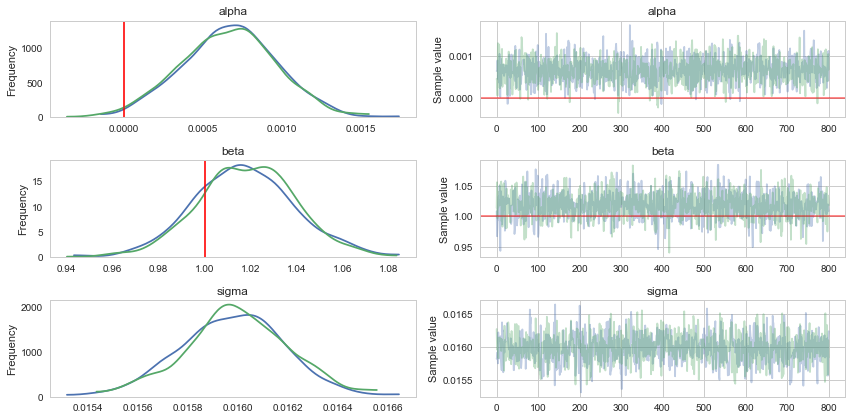

<Figure size 720x576 with 0 Axes>

In [45]:
# Plot the posteriors.
# I prefer R's approach to this, which uses histograms rather than smoothed density plots.

fig = pm.traceplot(trace[199:1000], lines={'alpha': 0, 'beta': 1})
plt.figure(figsize = (10, 8))

In [46]:
# Start with averages and 95% credible intervals.

print("Average alpha and its 95% credible interval are:", np.mean(trace['alpha'][199:1000]), np.percentile(trace['alpha'][199:1000], (2.5, 97.5)))
print("Average beta and its 95% credible interval are:", np.mean(trace['beta'][199:1000]), np.percentile(trace['beta'][199:1000], (2.5, 97.5)))
print()

# Test two valuable hypotheses.
# alpha > 0
# beta < 1
# These are key inputs to decision making.

print("The probability that alpha is greater than zero is", np.mean(trace['alpha'][199:1000] > 0.0))
print("The probability that beta is less than one is", np.mean(trace['beta'][199:1000] < 1.0))
print("The joint probability is", np.all([[trace['alpha'][199:1000] > 0.0], [trace['beta'][199:1000] < 1.0]], axis = 0).mean())

Average alpha and its 95% credible interval are: 0.00067861110157 [  8.83375878e-05   1.24677908e-03]
Average beta and its 95% credible interval are: 1.01723971958 [ 0.9751587   1.06134598]

The probability that alpha is greater than zero is 0.991260923845
The probability that beta is less than one is 0.215980024969
The joint probability is 0.213483146067


## Predicting Returns Using Deep Learning

In [47]:
# Do a train/test split of .8/.2

from sklearn.model_selection import train_test_split

data = pd.merge(nasdaq_returns, aapl_returns, left_index=True, right_index=True)
data.rename(columns={'Adj Close_x':'nasdaq', 'Adj Close_y':'aapl'}, inplace=True)
datatrain, datatest = train_test_split(data, test_size = 0.2, random_state=10191987)

In [48]:
# We need a baseline against which to compare the deep learner.  
# The most obvious is regression and its prediction or out-of-sample error, the MSE.

mod = smf.ols(formula='aapl ~ nasdaq', data = datatrain).fit()
datatrain['fitted'] = mod.predict(exog = datatrain)
datatest['fitted'] = mod.predict(exog = datatest)

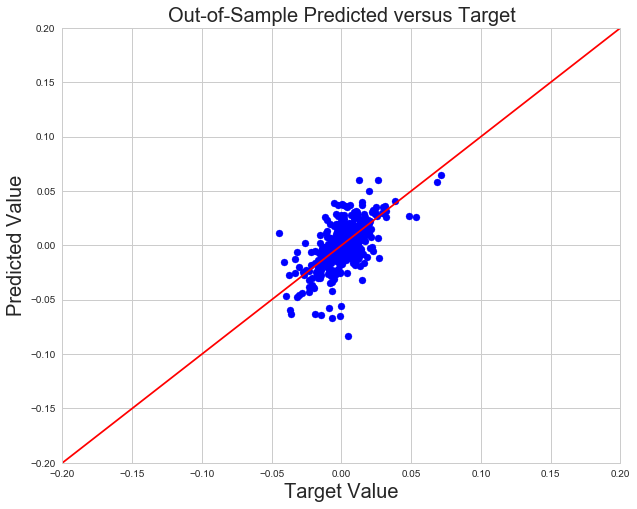

In [49]:
# Let's plot the out-of-sample predictions and compare with the target values 
# from the test set, together with a 45 degree line.
# A perfect predictor would yield a scatterplot clustered closely on the 45 degree line.
# Any values above the line indicate a prediction "overshoot".
# Any values below the line indicate a prediction "undershoot".

figure, ax = plt.subplots(figsize = (10, 8))
plt.scatter(datatest['fitted'], datatest['aapl'], color='blue')
plt.title('Out-of-Sample Predicted versus Target', fontsize = 20)
plt.xlabel('Target Value', fontsize = 20)
plt.ylabel('Predicted Value', fontsize = 20)
plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.plot(ax.get_ylim(), ax.get_ylim(), 'r-')

In [50]:
# The baseline against which to measure.

print('The average out-sample AAPL return is %f' % datatest['aapl'].mean())
print('The average predicted AAPL return is %f' % datatest['fitted'].mean())
print('The MSE is %f' % ((datatest['aapl'] - datatest['fitted'])**2).mean())

The average out-sample AAPL return is -0.000160
The average predicted AAPL return is 0.001143
The MSE is 0.000212


In [51]:
train_X = datatrain['nasdaq'].as_matrix()
train_y = datatrain['aapl'].as_matrix()
test_X = datatest['nasdaq'].as_matrix()
test_y = datatest['aapl'].as_matrix()

dim = 1

In [52]:
np.random.seed(1492)

model = Sequential()
model.add(Dense(units=500, activation='relu', input_dim=1))
model.add(Dense(units=1000, activation='relu', input_dim=1))
model.add(Dense(units=1000, activation='relu', input_dim=1))
model.add(Dense(units=1000, activation='relu', input_dim=1))
model.add(Dense(units=500, activation='relu', input_dim=1))
model.add(Dense(units=1))

# Compile, fit, and generate scores and predicted probabilities.
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#model.fit(data, labels, epochs=20, batch_size=100)
model.fit(train_X, train_y, epochs=20, batch_size=200, verbose=2)
target = model.predict(test_X)
datatest['target'] = target

Epoch 1/20
2s - loss: 5.3071e-04 - mean_squared_error: 5.3071e-04
Epoch 2/20
2s - loss: 3.2280e-04 - mean_squared_error: 3.2280e-04
Epoch 3/20
1s - loss: 2.9806e-04 - mean_squared_error: 2.9806e-04
Epoch 4/20
2s - loss: 2.7946e-04 - mean_squared_error: 2.7946e-04
Epoch 5/20
2s - loss: 3.2840e-04 - mean_squared_error: 3.2840e-04
Epoch 6/20
2s - loss: 2.9458e-04 - mean_squared_error: 2.9458e-04
Epoch 7/20
1s - loss: 2.7562e-04 - mean_squared_error: 2.7562e-04
Epoch 8/20
2s - loss: 2.7633e-04 - mean_squared_error: 2.7633e-04
Epoch 9/20
1s - loss: 3.0407e-04 - mean_squared_error: 3.0407e-04
Epoch 10/20
1s - loss: 3.4356e-04 - mean_squared_error: 3.4356e-04
Epoch 11/20
1s - loss: 3.1056e-04 - mean_squared_error: 3.1056e-04
Epoch 12/20
1s - loss: 2.8071e-04 - mean_squared_error: 2.8071e-04
Epoch 13/20
1s - loss: 2.7939e-04 - mean_squared_error: 2.7939e-04
Epoch 14/20
1s - loss: 2.8117e-04 - mean_squared_error: 2.8117e-04
Epoch 15/20
1s - loss: 2.8072e-04 - mean_squared_error: 2.8072e-04
Epoc

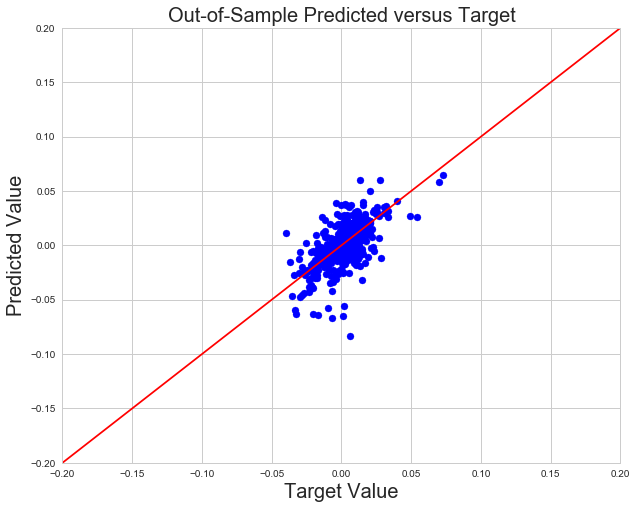

In [53]:
# Plot the results from the MLP.

figure, ax = plt.subplots(figsize = (10, 8))
plt.scatter(datatest['target'], datatest['aapl'], color='blue')
plt.title('Out-of-Sample Predicted versus Target', fontsize = 20)
plt.xlabel('Target Value', fontsize = 20)
plt.ylabel('Predicted Value', fontsize = 20)
plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.plot(ax.get_ylim(), ax.get_ylim(), 'r-')

In [54]:
print('The average out-sample AAPL return is %f' % datatest['aapl'].mean())
print('The average predicted AAPL return is %f' % datatest['target'].mean())
print('The MSE is %f' % ((datatest['aapl'] - datatest['target'])**2).mean())

The average out-sample AAPL return is -0.000160
The average predicted AAPL return is 0.002026
The MSE is 0.000215


### Interesting to Compare and Discuss
* Compare the baseline (regression) with deep learning.
* See https://github.com/thsavage/Deep-Learning-and-Finance/blob/master/Deep%20Learning%20and%20Finance%20Poster.pdf

In [55]:
# Regression Baseline.

print('The average out-sample AAPL return is %f' % datatest['aapl'].mean())
print('The average predicted AAPL return is %f' % datatest['fitted'].mean())
print('The MSE is %f' % ((datatest['aapl'] - datatest['fitted'])**2).mean())

The average out-sample AAPL return is -0.000160
The average predicted AAPL return is 0.001143
The MSE is 0.000212


In [56]:
# Deep learning.

print('The average out-sample AAPL return is %f' % datatest['aapl'].mean())
print('The average predicted AAPL return is %f' % datatest['target'].mean())
print('The MSE is %f' % ((datatest['aapl'] - datatest['target'])**2).mean())

The average out-sample AAPL return is -0.000160
The average predicted AAPL return is 0.002026
The MSE is 0.000215


### Why?  Think (Deeply) About Use Case

In [57]:
# Start with white noise.

np.random.seed(112358)
data = np.random.random((100000, 10))
labels = np.random.random((100000, 1))

dim = data.shape[1]
#dim

In [58]:
# Do an MLP with three hidden layers with 32, 64, and 32 neurons respectively as regression.

model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=dim))
model.add(Dense(units=64, activation='relu', input_dim=dim))
model.add(Dense(units=64, activation='relu', input_dim=dim))
model.add(Dense(units=32, activation='relu', input_dim=dim))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.fit(data, labels, epochs=10, batch_size=100, verbose=2)

Epoch 1/10
3s - loss: 0.0860 - mean_squared_error: 0.0860
Epoch 2/10
2s - loss: 0.0838 - mean_squared_error: 0.0838
Epoch 3/10
2s - loss: 0.0837 - mean_squared_error: 0.0837
Epoch 4/10
2s - loss: 0.0836 - mean_squared_error: 0.0836
Epoch 5/10
2s - loss: 0.0836 - mean_squared_error: 0.0836
Epoch 6/10
2s - loss: 0.0836 - mean_squared_error: 0.0836
Epoch 7/10
2s - loss: 0.0836 - mean_squared_error: 0.0836
Epoch 8/10
2s - loss: 0.0835 - mean_squared_error: 0.0835
Epoch 9/10
2s - loss: 0.0836 - mean_squared_error: 0.0836
Epoch 10/10
2s - loss: 0.0835 - mean_squared_error: 0.0835


In [59]:
# Generate more noise and push it through the fitted deep learner.

data_test = np.random.random((100000, 10))
predictions = model.predict(data_test)

In [60]:
# Look at means, variances, and MSE

print("The average label and prediction are %f and %f" % (labels.mean(), predictions.mean()))
print("The label and prediction variances are %f and %f" % (labels.var(), predictions.var()))
print("The MSE is %f" % mean_squared_error(labels, predictions))

The average label and prediction are 0.500327 and 0.485532
The label and prediction variances are 0.083463 and 0.000027
The MSE is 0.083716


In [61]:
print(labels[0:9])
print("")
print(predictions[0:9])

[[ 0.84202796]
 [ 0.07388025]
 [ 0.74088346]
 [ 0.10543352]
 [ 0.25740087]
 [ 0.74164567]
 [ 0.17063694]
 [ 0.73387526]
 [ 0.74127298]]

[[ 0.48860392]
 [ 0.48393127]
 [ 0.49045604]
 [ 0.49039462]
 [ 0.48238796]
 [ 0.487988  ]
 [ 0.48545337]
 [ 0.48468876]
 [ 0.47793081]]


## Homework

* Run all code above.
* Examine whether adding another layer improves the MLP for the Logit Gate.
* Examine whether an alternative set of prior probabilities, such as diffuse normal, impacts the results from the CAPM.
* Deploy the RNN on the Apple returns data.  Do you do any better?  